# Figure 2, S1, S2: TI-model & Calib option parameter distribution comparison plot

- creates three plots for the manuscript: 
    - `fig_2_calib_params_stats_point_plot.pdf`
        - parameter distribution plot of all options
    - Supplementary Figure S1: `fig_S1_calib_log_fit_pf_distribution_change_simple.pdf`
        - explain prcp. fac varying w. winter prcp. option E 
    - Supplementary Figure S2: `fig_S2_barplot_glaciers_per_region_all_options.pdf`
        - amount of glaciers that can be calibrated for all calibration and temperature-index model options


In [2]:
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
import xarray as xr

# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

pd_params_stats = pd.read_csv(f'{data_path}/0_pd_params_stats_not_working_for_all.csv', index_col =0)
pd_params_stats_working_for_all = pd.read_csv(f'{data_path}/0_pd_params_stats_working_for_all.csv')
# need to convert from monthly melt_f to daily melt_f (SI units)
fac_per_month_to_per_day = 365.25/12
pd_params_stats.loc[:, 'melt_f'] = pd_params_stats['melt_f'].values/fac_per_month_to_per_day
pd_params_stats_working_for_all.loc[:, 'melt_f'] = pd_params_stats_working_for_all['melt_f'].values/fac_per_month_to_per_day

In [4]:
# the different calibration options were initially named differently
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)'} 
calib_type_short = [r'$C_1$', r'$C_2$',r'$C_3$',r'$C_4$',r'$C_5$']
#calib_type_short = [r'$C_{gwstd}}$', r'$C_{gw}$',  r'$C_{gstd}$',   r'$C_{g:p_{f}cte}$',  r'$C_{g:p_{f}(w.prcp)}$']

### Fig. 2: Ti-model & calib option parameter distribution comparison plot**
- here only need those glaciers that work for all options (n=88) --> `pd_params_stats_working_for_all`

In [5]:
len(pd_params_stats_working_for_all.rgi_id.unique())

88

**Note that `mb_pseudo_daily_fake` corresponds to the pseudo-daily option of the manuscript with interannual constant temperature standard deviations. `mb_pseudo_daily`, however, corresponds to the varying pseudo-daily option where the daily temperatue standard deviation is derived from the actual daily future GCMs (this option has been shortly mentioned in Sect. 3).** 

Hence, for Fig. 2 below, we plot the distributions with the pseudo-daily option with interannual constant temp. std. :

In [6]:
warnings.filterwarnings('ignore')

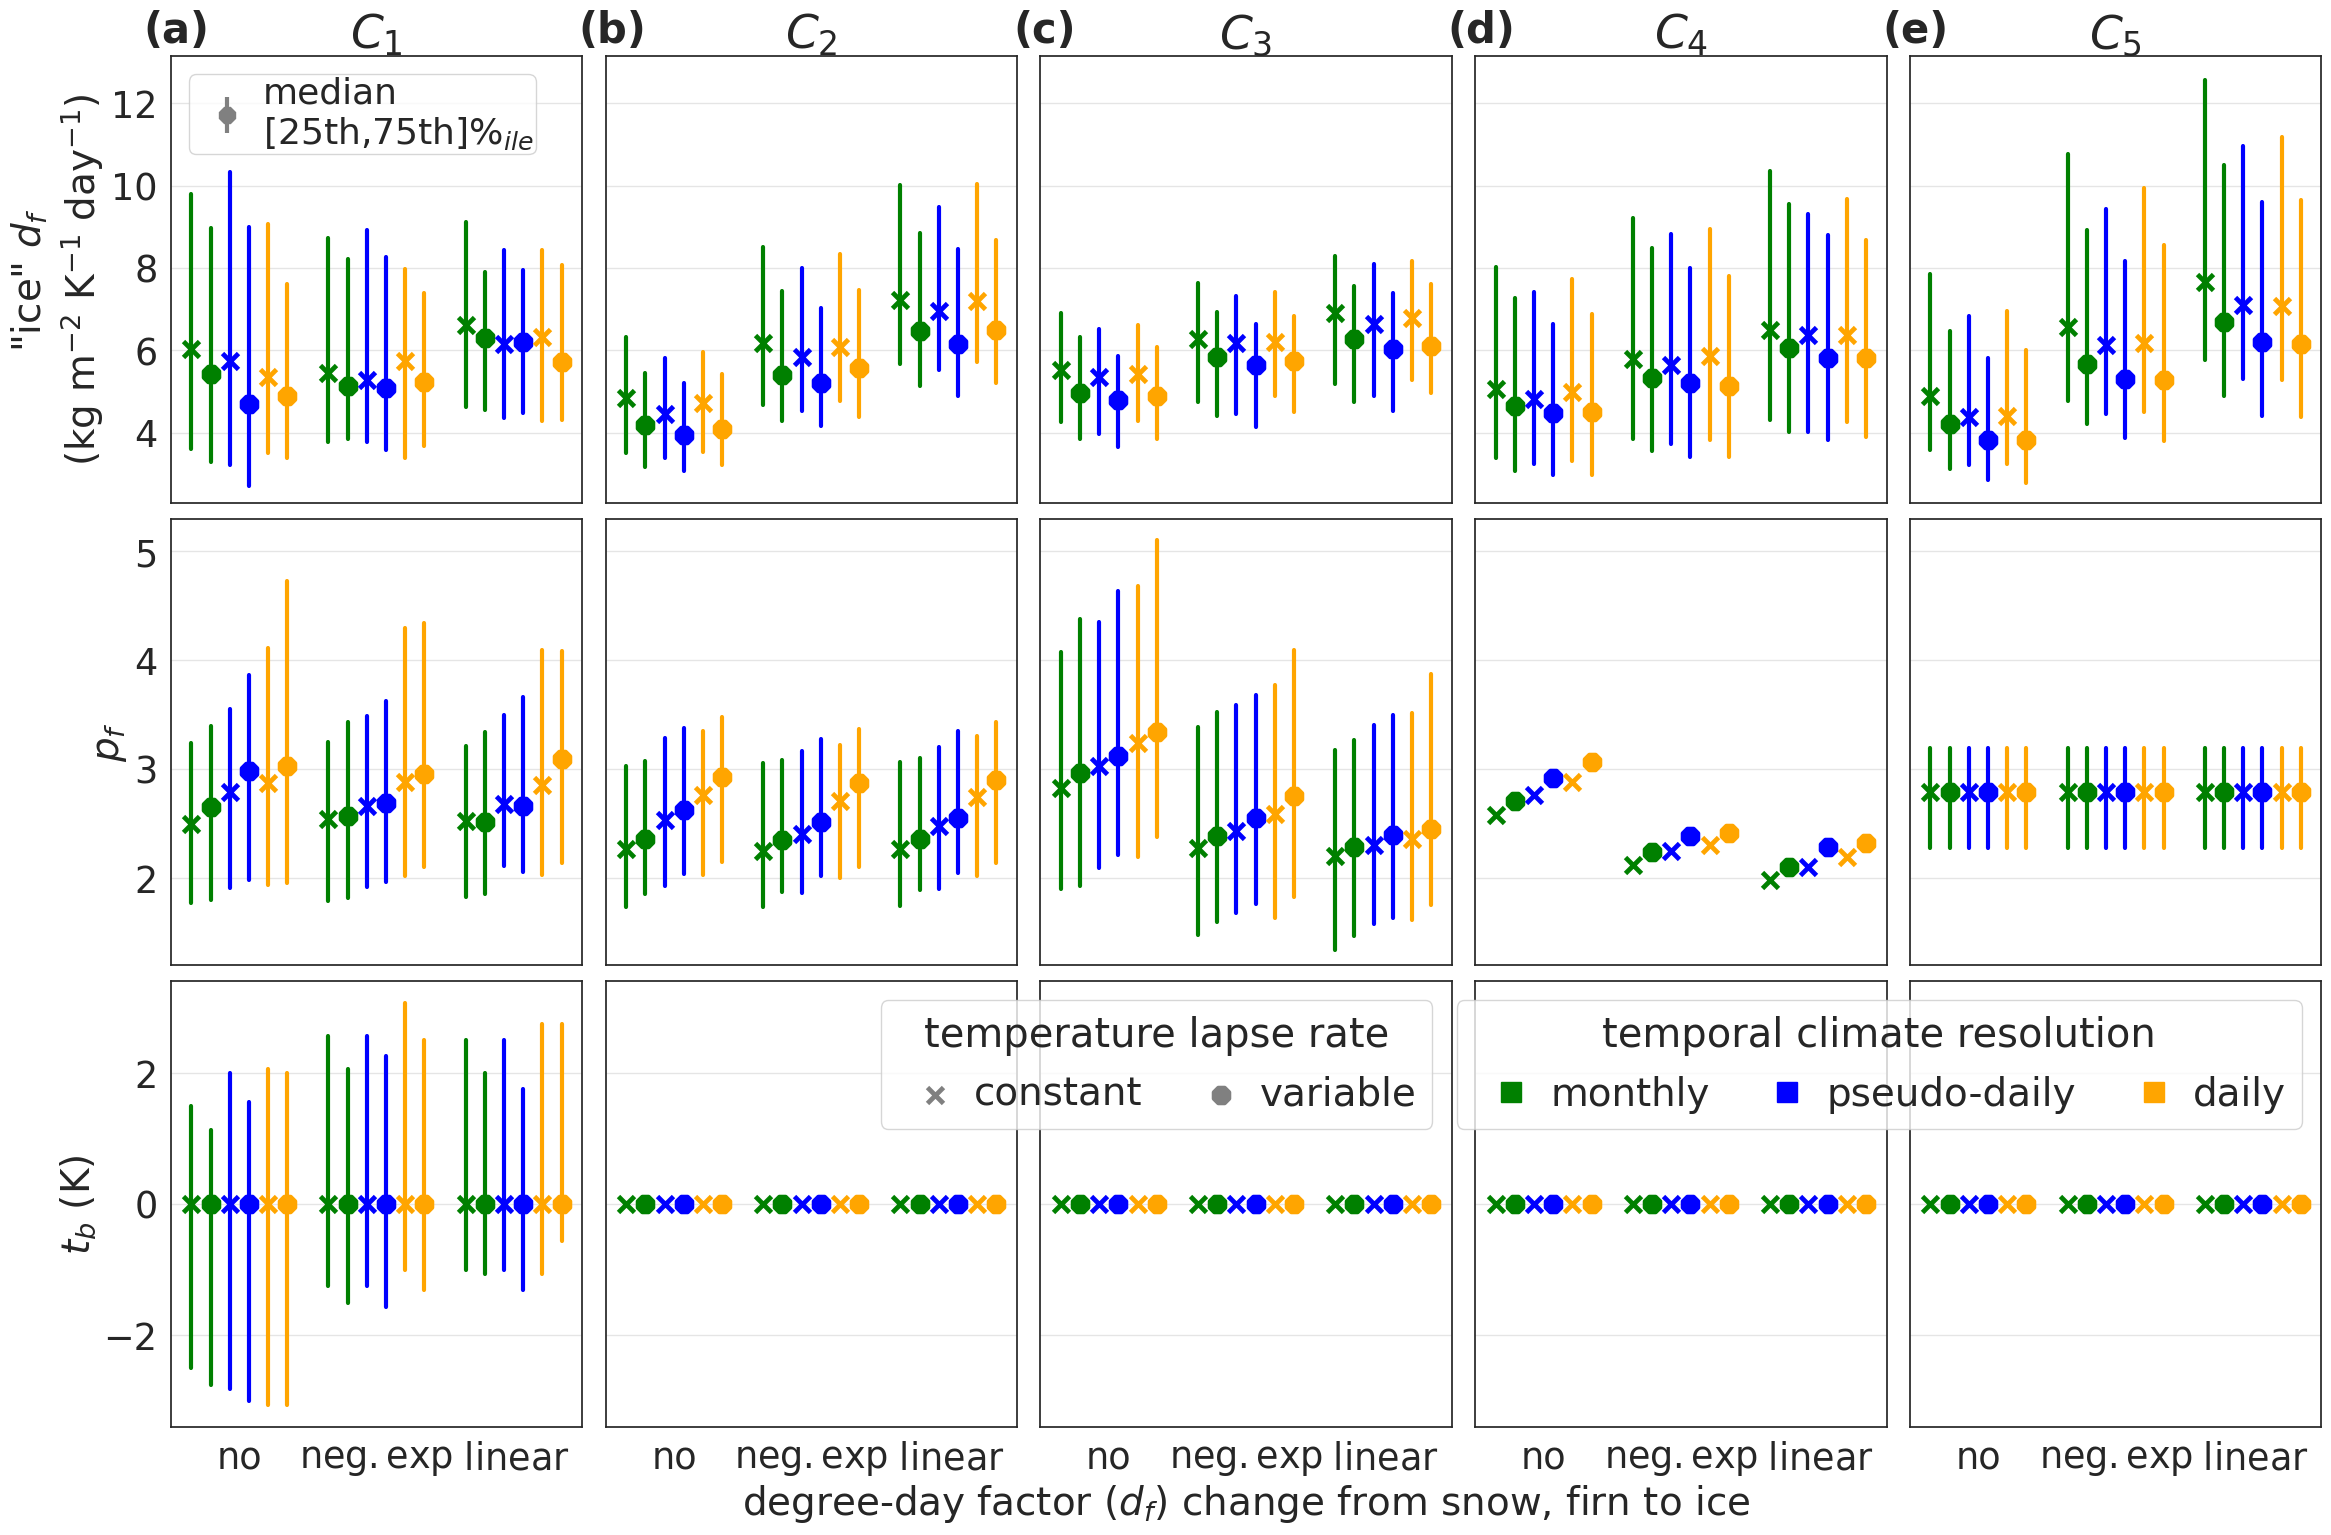

In [36]:
g = plt.errorbar([0], [3], yerr=[100], fmt = '8',markersize=12, label='median\n'+r'[25th,75th]%$_{ile}$', color = 'grey', elinewidth=3)
handles_spread, labels_spread = plt.gca().get_legend_handles_labels()
plt.close()

for apply_fake_pseudo_daily in [True]: #, False]:
    if apply_fake_pseudo_daily:
        hue_order = ['mb_monthly_cte', 'mb_monthly_var_an_cycle', 'mb_pseudo_daily_fake_cte',
               'mb_pseudo_daily_fake_var_an_cycle', 'mb_real_daily_cte',
               'mb_real_daily_var_an_cycle']
    else:
        hue_order = ['mb_monthly_cte', 'mb_monthly_var_an_cycle', 'mb_pseudo_daily_cte',
               'mb_pseudo_daily_var_an_cycle', 'mb_real_daily_cte',
               'mb_real_daily_var_an_cycle']

    sns.set(font_scale=2.4)
    sns.set_style('white')

    #col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
    col_pal = sns.color_palette(['green','green','blue','blue', #'cyan','cyan',
                                 'orange', 'orange'])

    markers = 3* ['x','8']

    fig, axs = plt.subplots(3, len(calib_types), sharex=True, #sharey=True,
                                figsize=(24,16)) # 30, 15
    order = ['False',   #'linear\nannual',
               'neg_exp\nmonthly',
             'linear\nmonthly'#'neg_exp\nannual'
                ]
    order2 = ['False', 'neg_exp\nmonthly_t1yr','linear\nmonthly']

    j = 0
    for p,param in enumerate(['melt_f', 'pf_opt', 'temp_bias']):
        #plt.plot(figsize=(30,20))
        for c,calib_type in enumerate(calib_types):
            if (calib_type == 'calib_only_geod_temp_b_0_cte_via_std') and (param == 'pf_opt'):
                marker = 's'
            else:
                marker = "8"
            pd_tt = pd_params_stats_working_for_all.loc[pd_params_stats_working_for_all.calib_type==calib_type]
            pd_tt = pd_tt.loc[(pd_tt.sfc_type != 'neg_exp\nannual_t1yr')
                              & (pd_tt.sfc_type != 'linear\nannual')]
            g=sns.pointplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type',
                            errorbar=('pi',50),
                            errwidth=3, 
                            hue_order = hue_order,
                            estimator=np.median,
                            palette=col_pal, ax = axs[p,c], #order=order,
                            dodge=0.7, join=False, n_boot=5000,
                            order = order2,
                            scale=1.7,
                            markers=markers,
                            #alpha=0.9
                         #showmeans=True,
                      #whis=0,
                      #flierprops = dict(markerfacecolor='silver', markersize=6,
                      #    markeredgecolor='none'),
                    #meanprops={"marker": marker,
                    #           "markeredgecolor": "grey",
                    #           "markerfacecolor": "grey",
                    #           "markersize": "10"}
                           )
            g.set_xlabel(f'degree-day factor ($d_f$) change from snow, firn to ice', fontsize=28)
            g.set_xticklabels(['no', f'neg.$\\,$exp$\\,$', '$\\,$linear'])

            #g.set_xticklabels(['no', 'yes\n(neg_exp)'+r'$\,\,\,\,\,\,\,$' , 'yes\n'+r'$\,\,\,\,\,\,\,\,$(linear)'])
                             #fontsize=26)
            #g.set_yticklabels(fontsize=26)
            handles, labels = g.get_legend_handles_labels()
            g.get_legend().remove()
            #if c==4 or p== 2:

            if p == 0:
                axs[p,c].set_title(calib_type_short[c], fontsize=34)
                axs[p,c].text(-0.7,410/fac_per_month_to_per_day, num_dict[c],
                              fontsize=30, weight='bold')

            if p!= 2 or c!=2:
                axs[p,c].set_xlabel('')
            axs[p,c].grid(axis='y', alpha = 0.5)

            if param=='pf_opt':
                axs[p,c].set_ylim([1.2,5.3])
                axs[p,c].set_ylabel(r'$p_{f}$', fontsize=28) #precipitation factor')
            elif param == 'melt_f':
                axs[p,c].set_ylim(np.array([70,400])/fac_per_month_to_per_day)
                axs[p,c].set_ylabel(r'"ice" $d_{f}$'+'\n'+'(kg m$^{-2}$ K$^{-1}$ day$^{-1}$)',
                                    fontsize=28) #"ice" melt factor (kg m$^{-2}$ K$^{-1}$ day$^{-1}$)')
            else:
                axs[p,c].set_ylim(np.array([-3.4,3.4]))
                axs[p,c].set_ylabel(r'$t_{b}$ (K)', fontsize=28) #'   #temperature bias (°C)')
            if c!=0:
                axs[p,c].set_ylabel('')
                axs[p,c].set_yticklabels('')

            j += 1

    plt.tight_layout(w_pad=0.05, h_pad=0.4)
    labels_new = ['monthly', 'monthly',
                  'pseudo-daily',
                  'pseudo-daily',
                  #'fake pseudo-daily', 'fake pseudo-daily',
                  'daily', 'daily']
    
    from matplotlib.lines import Line2D
    handles_temp_clim = [Line2D([0], [0], ls='',marker='s', color=col_pal[0], markersize=15),
                         Line2D([0], [0], ls='',marker='s', color=col_pal[2], markersize=15),
                         Line2D([0], [0], ls='',marker='s', color=col_pal[4], markersize=15)]

    axs[2,4].legend(handles_temp_clim, labels_new[::2],
                   title='temporal climate resolution',
                   columnspacing = 1,
                   handletextpad = 0.01,
                   #labelspacing=0.04,
                   ncol=3,fontsize=28, loc = 'upper right')

    h_l_r = handles[:2].copy()
    h_l_r[0].set_color('grey')
    h_l_r[1].set_color('grey')

    axs[2,2].legend(handles[:2], ['constant', 'variable'] ,
                   title='temperature lapse rate',
                   columnspacing = 1,
                   handletextpad = 0.01,
                   #labelspacing=0.04,
                   ncol=2,fontsize=28,
                    loc = 'upper right')
    h_l_r[0].set_color('green')
    h_l_r[1].set_color('green')
    
    #plt.legend(handles_spread, labels_spread,  markerscale=5)
    axs[0,0].legend(handles_spread, labels_spread, fontsize=26, loc='upper left', handletextpad = 0.001, borderpad=0.05)

    #plt.savefig(f'{fig_path}/calib_params_stats_point_plot_new_C.pdf')
    if apply_fake_pseudo_daily:
        plt.savefig(f'{fig_path}/fig_2_median_iqr_calib_params_stats_point_plot_large_w_fake_pseudo_daily.pdf') 
    else:
        # not used in manuscript
        plt.savefig(f'{fig_path}/calib_params_stats_point_plot_large.pdf')

### Old Figure variant with mean and its 95% confidence interval:

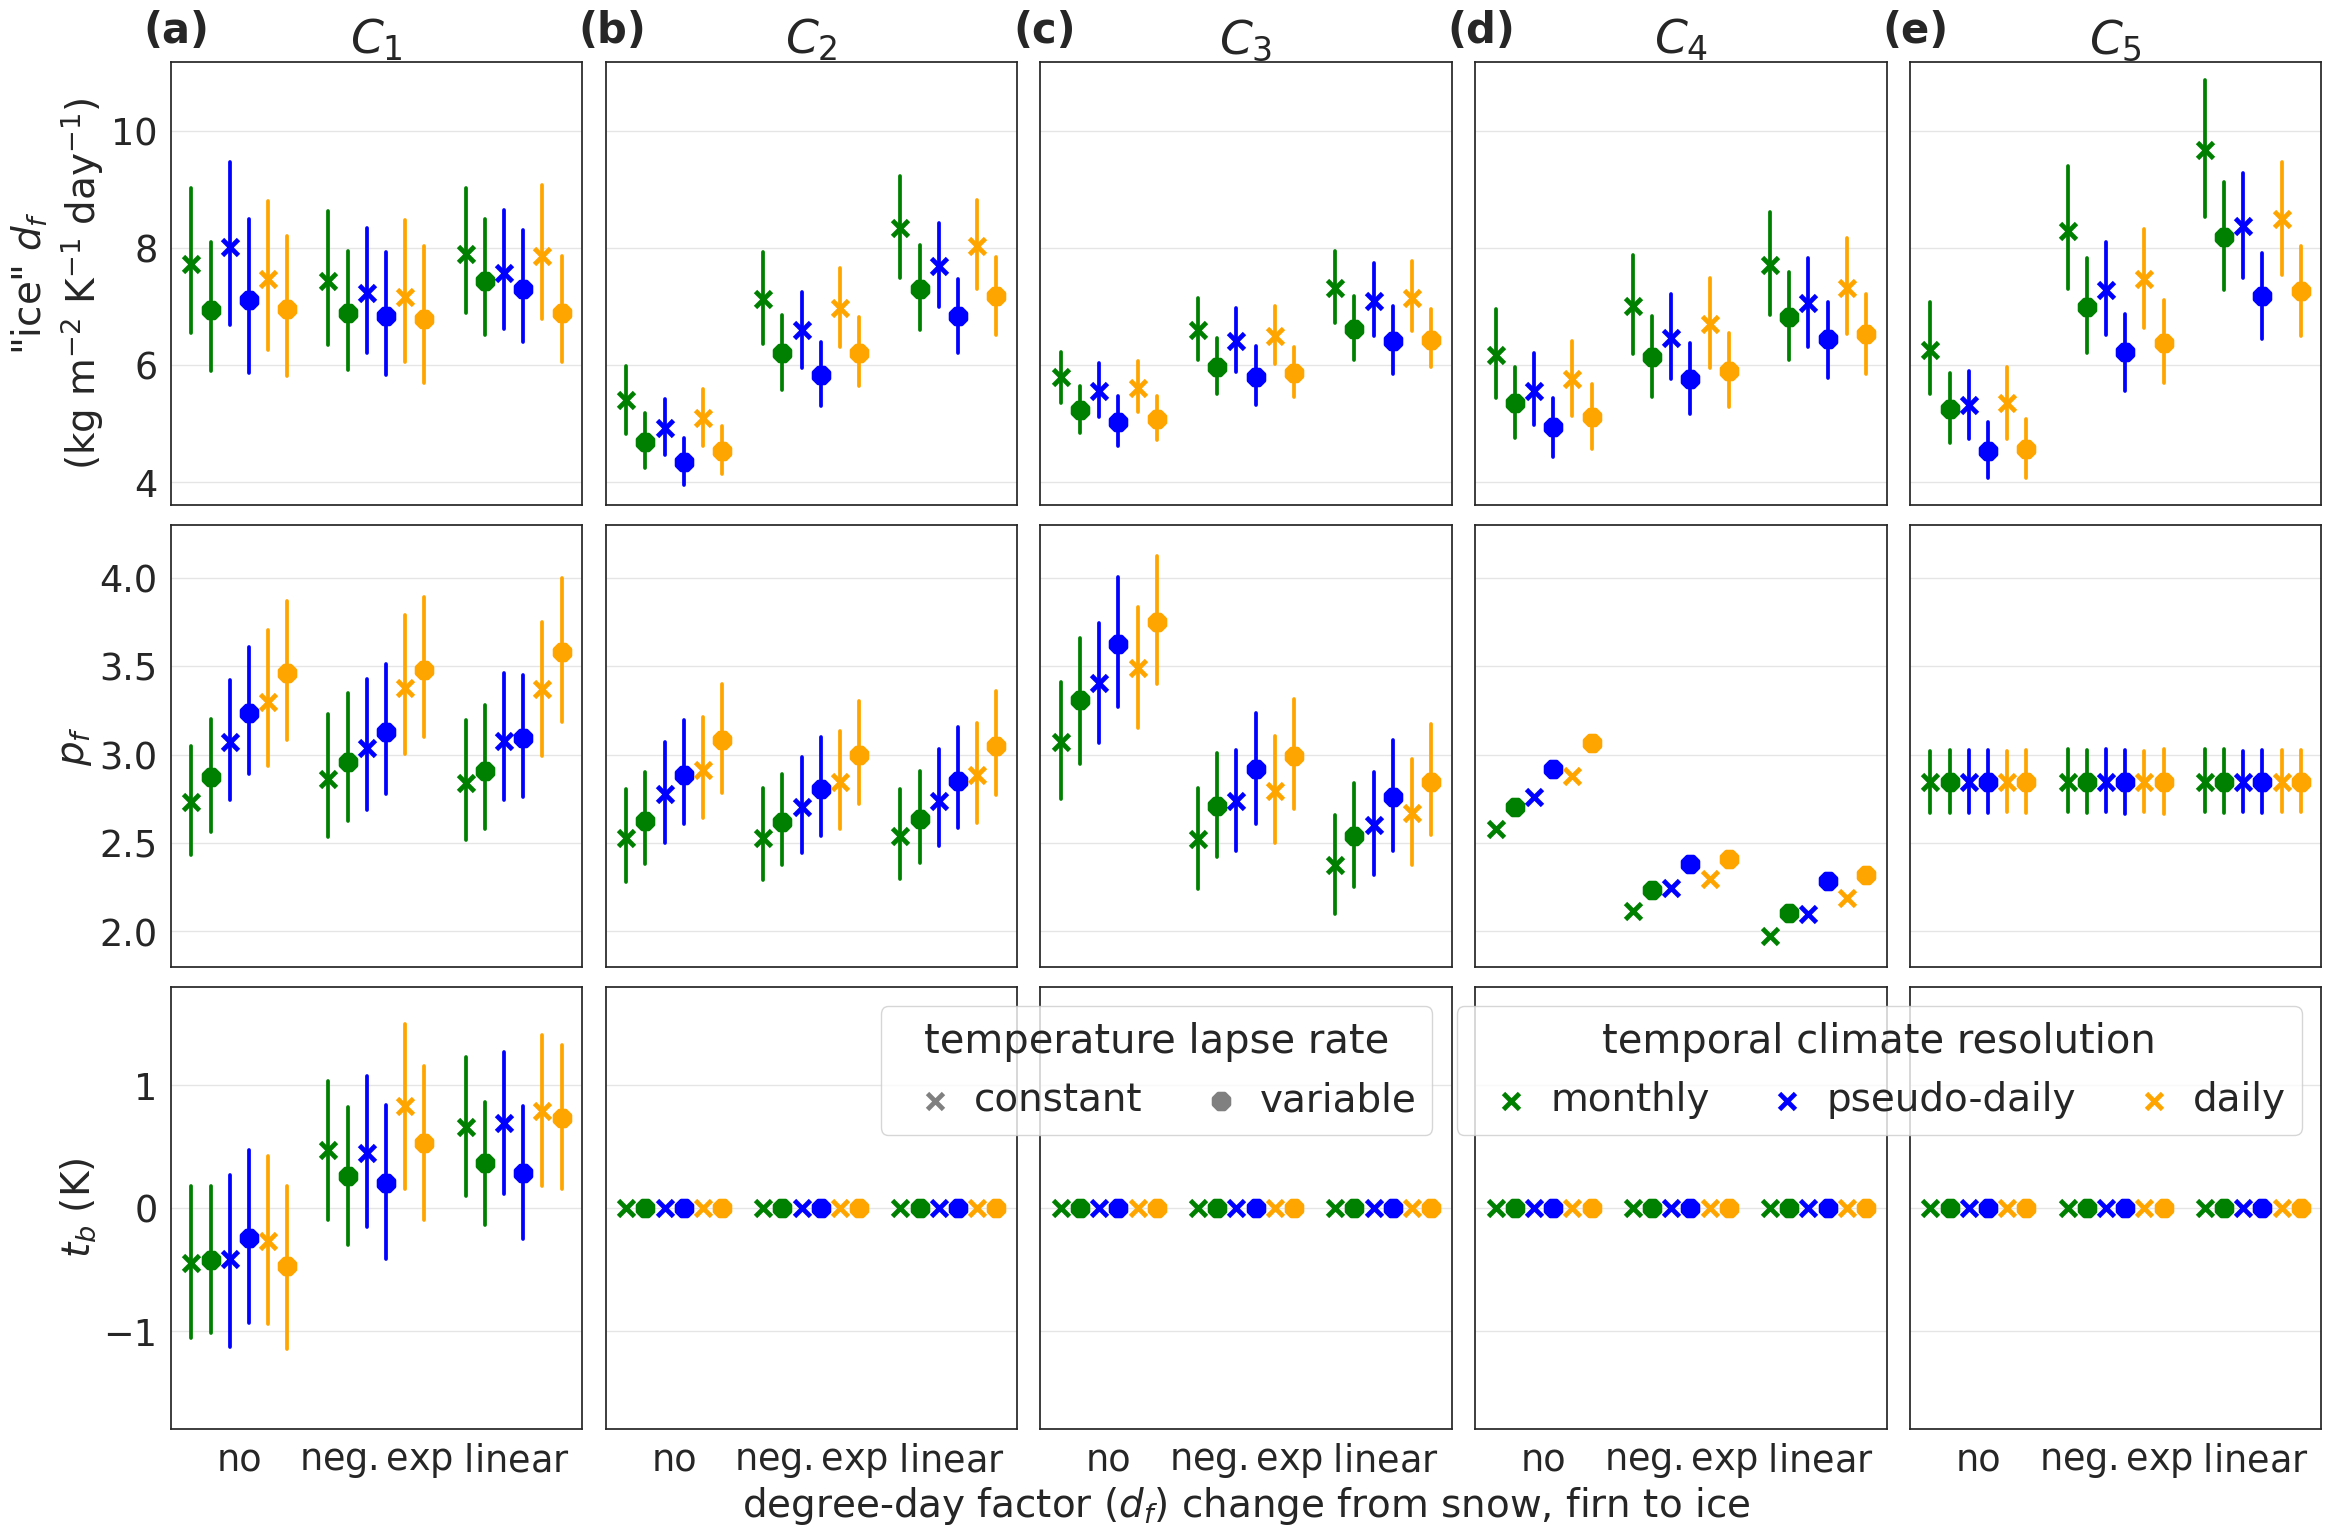

In [6]:
for apply_fake_pseudo_daily in [True]: #, False]:
    if apply_fake_pseudo_daily:
        hue_order = ['mb_monthly_cte', 'mb_monthly_var_an_cycle', 'mb_pseudo_daily_fake_cte',
               'mb_pseudo_daily_fake_var_an_cycle', 'mb_real_daily_cte',
               'mb_real_daily_var_an_cycle']
    else:
        hue_order = ['mb_monthly_cte', 'mb_monthly_var_an_cycle', 'mb_pseudo_daily_cte',
               'mb_pseudo_daily_var_an_cycle', 'mb_real_daily_cte',
               'mb_real_daily_var_an_cycle']

    sns.set(font_scale=2.4)
    sns.set_style('white')

    #col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
    col_pal = sns.color_palette(['green','green','blue','blue', #'cyan','cyan',
                                 'orange', 'orange'])

    markers = 3* ['x','8']

    fig, axs = plt.subplots(3, len(calib_types), sharex=True, #sharey=True,
                                figsize=(24,16)) # 30, 15
    order = ['False',   #'linear\nannual',
               'neg_exp\nmonthly',
             'linear\nmonthly'#'neg_exp\nannual'
                ]
    order2 = ['False', 'neg_exp\nmonthly_t1yr','linear\nmonthly']

    j = 0
    for p,param in enumerate(['melt_f', 'pf_opt', 'temp_bias']):
        #plt.plot(figsize=(30,20))
        for c,calib_type in enumerate(calib_types):
            if (calib_type == 'calib_only_geod_temp_b_0_cte_via_std') and (param == 'pf_opt'):
                marker = 's'
            else:
                marker = "8"
            pd_tt = pd_params_stats_working_for_all.loc[pd_params_stats_working_for_all.calib_type==calib_type]
            pd_tt = pd_tt.loc[(pd_tt.sfc_type != 'neg_exp\nannual_t1yr')
                              & (pd_tt.sfc_type != 'linear\nannual')]
            g=sns.pointplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type',
                            hue_order = hue_order,
                            palette=col_pal, ax = axs[p,c], #order=order,
                            dodge=0.7, join=False, n_boot=5000,
                            order = order2,
                            scale=1.7,
                            markers=markers,
                         #showmeans=True,
                      #whis=0,
                      #flierprops = dict(markerfacecolor='silver', markersize=6,
                      #    markeredgecolor='none'),
                    #meanprops={"marker": marker,
                    #           "markeredgecolor": "grey",
                    #           "markerfacecolor": "grey",
                    #           "markersize": "10"}
                           )
            g.set_xlabel(f'degree-day factor ($d_f$) change from snow, firn to ice', fontsize=28)
            g.set_xticklabels(['no', f'neg.$\\,$exp$\\,$', '$\\,$linear'])

            #g.set_xticklabels(['no', 'yes\n(neg_exp)'+r'$\,\,\,\,\,\,\,$' , 'yes\n'+r'$\,\,\,\,\,\,\,\,$(linear)'])
                             #fontsize=26)
            #g.set_yticklabels(fontsize=26)
            handles, labels = g.get_legend_handles_labels()
            g.get_legend().remove()
            #if c==4 or p== 2:

            if p == 0:
                axs[p,c].set_title(calib_type_short[c], fontsize=34)
                axs[p,c].text(-0.7,350/fac_per_month_to_per_day, num_dict[c],
                              fontsize=30, weight='bold')

            if p!= 2 or c!=2:
                axs[p,c].set_xlabel('')
            axs[p,c].grid(axis='y', alpha = 0.5)

            if param=='pf_opt':
                axs[p,c].set_ylim([1.8,4.3])
                axs[p,c].set_ylabel(r'$p_{f}$', fontsize=28) #precipitation factor')
            elif param == 'melt_f':
                axs[p,c].set_ylim(np.array([110,340])/fac_per_month_to_per_day)
                axs[p,c].set_ylabel(r'"ice" $d_{f}$'+'\n'+'(kg m$^{-2}$ K$^{-1}$ day$^{-1}$)',
                                    fontsize=28) #"ice" melt factor (kg m$^{-2}$ K$^{-1}$ day$^{-1}$)')
            else:
                axs[p,c].set_ylim(np.array([-1.8,1.8]))
                axs[p,c].set_ylabel(r'$t_{b}$ (K)', fontsize=28) #'   #temperature bias (°C)')
            if c!=0:
                axs[p,c].set_ylabel('')
                axs[p,c].set_yticklabels('')

            j += 1

    plt.tight_layout(w_pad=0.05, h_pad=0.4)
    labels_new = ['monthly', 'monthly', 'pseudo-daily',
                  'pseudo-daily',
                  #'fake pseudo-daily', 'fake pseudo-daily',
                  'daily', 'daily']

    axs[2,4].legend(handles[::2], labels_new[::2],
                   title='temporal climate resolution',
                   columnspacing = 1,
                   handletextpad = 0.01,
                   #labelspacing=0.04,
                   ncol=3,fontsize=28, loc = 'upper right')

    h_l_r = handles[:2].copy()
    h_l_r[0].set_color('grey')
    h_l_r[1].set_color('grey')

    axs[2,2].legend(handles[:2], ['constant', 'variable'] ,
                   title='temperature lapse rate',
                   columnspacing = 1,
                   handletextpad = 0.01,
                   #labelspacing=0.04,
                   ncol=2,fontsize=28,
                    loc = 'upper right')
    h_l_r[0].set_color('green')
    h_l_r[1].set_color('green')

    #plt.savefig(f'{fig_path}/calib_params_stats_point_plot_new_C.pdf')
    #if apply_fake_pseudo_daily:
    #    plt.savefig(f'{fig_path}/fig_2_calib_params_stats_point_plot_large_w_fake_pseudo_daily.pdf') 
    #else:
    #    # not used in manuscript
    #    plt.savefig(f'{fig_path}/calib_params_stats_point_plot_large.pdf')

**Extract some statistics about the reference MB model in OGGM using most observational data:**

In [125]:
melt_f_ref = pd_params_stats_working_for_all.loc[(pd_params_stats_working_for_all.calib_type == 'calib_geod_opt_winter_mb_approx_std') & (pd_params_stats_working_for_all.mb_grad_type=='mb_monthly_cte') & (pd_params_stats_working_for_all.sfc_type=='False')]['melt_f']

In [126]:
melt_f_ref.mean() #* fac_per_month_to_per_day

7.729817968392168

In [59]:
melt_f_ref.quantile([0,0.05,0.25,0.5,0.75,0.95,1]).round(2)

0.00     1.36
0.05     1.98
0.25     3.61
0.50     6.02
0.75     9.80
0.95    20.43
1.00    29.88
Name: melt_f, dtype: float64

In [60]:
(melt_f_ref.quantile([0,0.05,0.25,0.5,0.75,0.95,1]) * fac_per_month_to_per_day).round(1)

0.00     41.5
0.05     60.3
0.25    109.9
0.50    183.2
0.75    298.3
0.95    621.7
1.00    909.5
Name: melt_f, dtype: float64

**Stats for the text**:

In [7]:
condi = pd_params_stats_working_for_all.mb_type != 'mb_pseudo_daily'
pd_params_stats_working_for_all_w_fake_pseudo_daily = pd_params_stats_working_for_all.loc[condi]

In [8]:
print(pd_params_stats_working_for_all_w_fake_pseudo_daily['melt_f'].quantile([0.025,0.25,0.5,0.75,0.975]))
print('IQR')
print(pd_params_stats_working_for_all_w_fake_pseudo_daily['melt_f'].quantile(0.75) - pd_params_stats_working_for_all_w_fake_pseudo_daily['melt_f'].quantile(0.25))

0.025     2.102768
0.250     4.086791
0.500     5.919661
0.750     8.258289
0.975    16.979782
Name: melt_f, dtype: float64
IQR
4.171497723708128


In [9]:
print(pd_params_stats_working_for_all_w_fake_pseudo_daily['pf_opt'].quantile([0.025,0.25,0.5,0.75,0.975]))
print('IQR')
print(pd_params_stats_working_for_all_w_fake_pseudo_daily['pf_opt'].quantile(0.75) - pd_params_stats_working_for_all_w_fake_pseudo_daily['pf_opt'].quantile(0.25))

0.025    0.968648
0.250    1.977146
0.500    2.412226
0.750    3.149775
0.975    5.946432
Name: pf_opt, dtype: float64
IQR
1.1726291197309047


In [10]:
print(pd_params_stats_working_for_all_w_fake_pseudo_daily.loc[pd_params_stats_working_for_all_w_fake_pseudo_daily.calib_type==calib_types[0]]['temp_bias'].quantile([0.025,0.25,0.5,0.75,0.975]))
print('IQR')
print(pd_params_stats_working_for_all_w_fake_pseudo_daily.loc[pd_params_stats_working_for_all_w_fake_pseudo_daily.calib_type==calib_types[0]]['temp_bias'].quantile(0.75) - pd_params_stats_working_for_all.loc[pd_params_stats_working_for_all.calib_type==calib_types[0]]['temp_bias'].quantile(0.25))

0.025   -5.60625
0.250   -1.75000
0.500    0.00000
0.750    2.25000
0.975    6.25000
Name: temp_bias, dtype: float64
IQR
4.0


- error bars: 95% confidence interval of the mean

**Stats for Hintereisferner**:

In [11]:
pd_hef = pd_params_stats_working_for_all_w_fake_pseudo_daily.loc[pd_params_stats_working_for_all_w_fake_pseudo_daily.rgi_id == 'RGI60-11.00897']

In [12]:
pd_hef_ref = pd_hef.loc[(pd_hef.mb_type=='mb_monthly')&(pd_hef.grad_type=='cte')]
pd_hef_ref = pd_hef_ref.loc[pd_hef_ref.sfc_type=='False']
pd_hef_ref.index = pd_hef_ref['calib_type']
pd_hef_ref

,rgi_id,rgi_id.1,temp_bias,pf_opt,melt_f,winter_prcp_mean,winter_solid_prcp_mean,specific_melt_winter_kg_m2,except_necessary,quot_std,...,sfc_type_distinction,changing melt_f with sfc type,calib_type,daily_yearly_prcp_mean_historical,daily_winter_prcp_mean_historical,hemisphere,area,bias_winter_mb,mb_grad_type,sfc_type
calib_type,,,,,,,,,,,,,,,,,,,,,
calib_geod_opt_winter_mb_approx_std,RGI60-11.00897,RGI60-11.00897,5.75,5.031414,2.529558,1926.802692,1520.255937,267.827366,0.0,1.097116,...,False,False,calib_geod_opt_winter_mb_approx_std,NaN,NaN,NaN,NaN,NaN,mb_monthly_cte,False
calib_geod_opt_winter_mb_temp_b_0,RGI60-11.00897,RGI60-11.00897,0.00,3.311146,12.854209,1268.018215,1263.997601,11.569030,0.0,2.298904,...,False,False,calib_geod_opt_winter_mb_temp_b_0,2.222625,1.703136,nh,8.036,NaN,mb_monthly_cte,False
calib_geod_opt_std_temp_b_0,RGI60-11.00897,RGI60-11.00897,0.00,0.696976,6.364130,266.910138,266.063823,5.727837,0.0,1.000128,...,False,False,calib_geod_opt_std_temp_b_0,NaN,NaN,NaN,NaN,-992.092585,mb_monthly_cte,False
calib_only_geod_temp_b_0_pf_cte_via_std,RGI60-11.00897,RGI60-11.00897,0.00,2.577183,11.032034,986.943876,983.814489,9.929038,0.0,1.931768,...,False,False,calib_only_geod_temp_b_0_pf_cte_via_std,NaN,NaN,NaN,NaN,-278.543120,mb_monthly_cte,False
calib_only_geod_temp_b_0_pf_fit_via_winter_mb,RGI60-11.00897,RGI60-11.00897,0.00,3.477374,13.266897,1331.676083,1327.453625,11.940456,0.0,2.382165,...,False,False,calib_only_geod_temp_b_0_pf_fit_via_winter_mb,NaN,NaN,NaN,NaN,63.084597,mb_monthly_cte,False


In [13]:
pd_hef_ref['winter_prcp_mean']/pd_hef_ref['pf_opt']/ (365.25/30)  # kg m$^{-2}$ day$^{-1}$

calib_type
calib_geod_opt_winter_mb_approx_std              31.454167
calib_geod_opt_winter_mb_temp_b_0                31.454167
calib_geod_opt_std_temp_b_0                      31.454167
calib_only_geod_temp_b_0_pf_cte_via_std          31.454167
calib_only_geod_temp_b_0_pf_fit_via_winter_mb    31.454167
dtype: float64

**Temperature lapse rate analysis for text parts of the manuscript:**

Text(0, 0.5, 'temperature lapse rate')

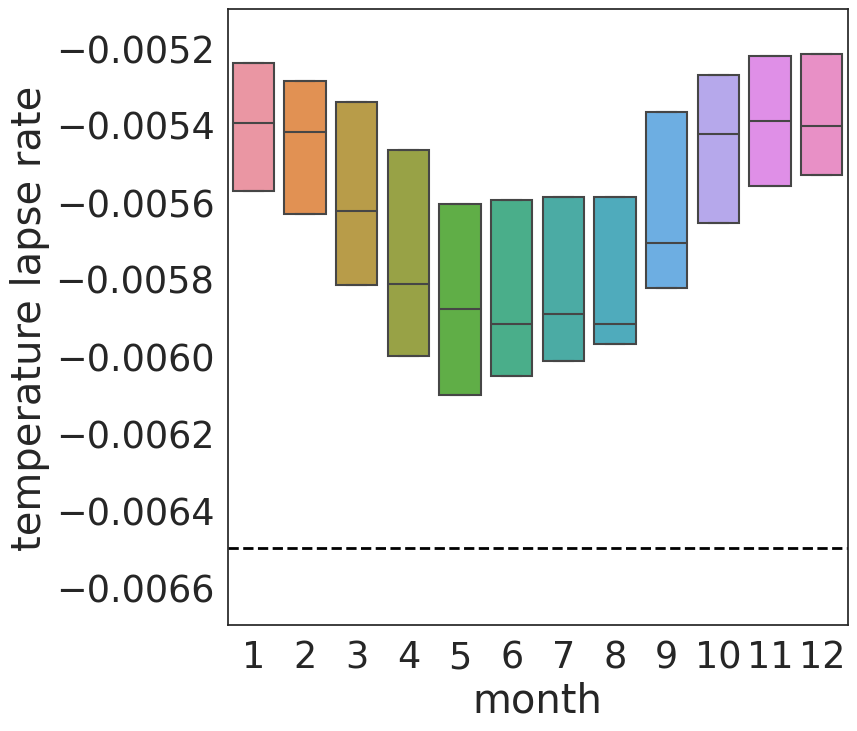

In [14]:
ref_candidates = pd_params_stats_working_for_all_w_fake_pseudo_daily.rgi_id.unique()

load = False
if load:
    # path where OGGM gdirs are: is created in data_creating_scripts
    working_dir = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/oggm_run_gdir_folder/node_folder'
    
    cfg.initialize()
    cfg.PARAMS['use_multiprocessing'] = True #True
    cfg.PATHS['working_dir'] = working_dir
    cfg.PARAMS['hydro_month_nh'] = 1
    cfg.PARAMS['hydro_month_sh'] = 1
    cfg.PARAMS['continue_on_error'] = True
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
    gdirs = workflow.init_glacier_directories(ref_candidates)
    pd_grad_m = pd.DataFrame(columns = ['gradient', 'month', 'rgi_id'], index=np.arange(len(gdirs)*12))
    
    j = 0
    for j,gdir in enumerate(gdirs): 
        _ds_clim = xr.open_dataset(gdir.get_filepath('climate_historical',
                                                     filesuffix='_daily_W5E5')).groupby('time.month').mean().gradient
        pd_grad_m.loc[j*12:j*12+11, 'gradient'] =  _ds_clim.values
        pd_grad_m.loc[j*12:j*12+11, 'month'] =  _ds_clim.month.values
        pd_grad_m.loc[j*12:j*12+11, 'rgi_id'] = gdir.rgi_id
        pd_grad_m.loc[j*12:j*12+11, 'hemisphere'] = gdir.hemisphere
    pd_grad_m.to_csv(f'{data_path}/1_lapse_rate_gradients_reference_glaciers.csv')
else:
    pd_grad_m = pd.read_csv(f'{data_path}/1_lapse_rate_gradients_reference_glaciers.csv',
                            index_col = 0)
    
#season_cols = sns.color_palette('Blues',n_colors=3) + sns.color_palette('Greens', n_colors=3) + sns.color_palette('Reds', n_colors=3) + sns.color_palette('Oranges', n_colors=3)
#season_cols = season_cols[1:].append(season_cols[0])
plt.figure(figsize=(8,8))
ax = plt.gca()
sns.boxplot(x='month', y='gradient', data=pd_grad_m, fliersize=0, whis=0, ax = ax)
ax.axhline(-0.0065, color = 'black', lw = 2, ls = '--')
ax.set_ylim([-0.0067,-0.0051])
ax.set_ylabel('temperature lapse rate')

just northern hemisphere: 

In [16]:
pd_grad_m_nh = pd_grad_m.loc[(pd_grad_m.hemisphere == 'nh')]
len(pd_grad_m_nh.rgi_id.unique())

84

In [17]:
print('Summer (May-September) temperature lapse rates in NH for common running glaciers')
(pd_grad_m_nh.where((pd_grad_m_nh.month >4) & (pd_grad_m_nh.month <10)).dropna()).quantile([0.25, 0.5, 0.75])*1000

Summer (May-September) temperature lapse rates in NH for common running glaciers


,gradient,month
0.25,-6.022490,6000.0
0.50,-5.826747,7000.0
0.75,-5.577255,8000.0


In [18]:
print('Winter (October-April) temperature lapse rates in NH for common running glaciers')
(pd_grad_m_nh.where((pd_grad_m_nh.month <5) | (pd_grad_m_nh.month >9)).dropna()).quantile([0.25, 0.5, 0.75])*1000

Winter (October-April) temperature lapse rates in NH for common running glaciers


,gradient,month
0.25,-5.663636,2000.0
0.50,-5.490924,4000.0
0.75,-5.262793,11000.0


In [19]:
print('total quantiles of all glaciers')
pd_grad_m.quantile([0.25, 0.5, 0.75])*1000

total quantiles of all glaciers


,gradient,month
0.25,-5.922243,3750.0
0.50,-5.594052,6500.0
0.75,-5.340339,9250.0


- with a larger lapse rate, automatically also have a larger MB gradient ... 
- including sfy type distinction, also leads to larger MB gradients, specifically with a linear decaying melt factor
- it seems that using both linear melt f achange  and variable lapse rates over estimates MB gradient, while using neg_exp with variable lapse rate is ok ... 

**amount of working glaciers -> Fig. S2**

In [20]:
pd_params_stats_working_for_all_avg_rgi = pd_params_stats_working_for_all_w_fake_pseudo_daily.groupby('rgi_id').mean()
pd_params_stats_working_for_all_avg_rgi['rgi_reg'] = 'NaN'
for r in pd_params_stats_working_for_all_avg_rgi.index:
    pd_params_stats_working_for_all_avg_rgi.loc[r,'rgi_reg'] = r[6:8]
all_rgi_reg = ['01', '02', '03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

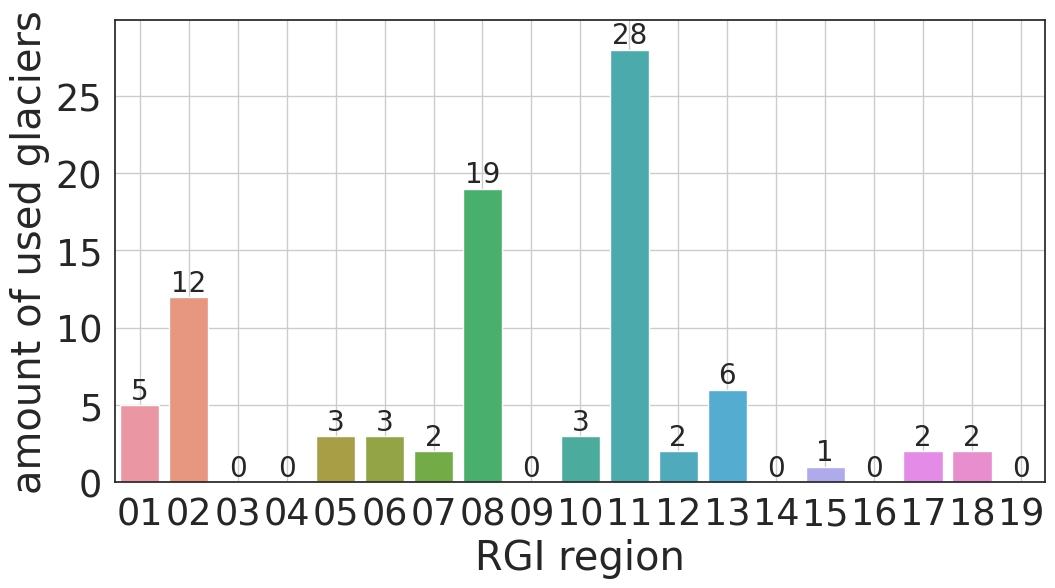

In [21]:
plt.rc('font', size=20)

plt.figure(figsize=(12,6))
plt.ylim([0,29.9])
pd_rgi_count = pd_params_stats_working_for_all_avg_rgi.groupby('rgi_reg').count()
pd_rgi_count['rgi_reg2'] = pd_rgi_count.index
pd_rgi_count['amount of calibrated glaciers'] = pd_rgi_count['temp_bias'] #just any values
for reg in all_rgi_reg:
    if reg not in pd_rgi_count.rgi_reg2:
        pd_rgi_count.loc[reg, 'amount of calibrated glaciers'] = 0
        pd_rgi_count.loc[reg, 'rgi_reg2'] = reg
pd_rgi_count = pd_rgi_count.sort_values(by='rgi_reg2')
splot=sns.barplot(y='amount of calibrated glaciers', x='rgi_reg2',
            data= pd_rgi_count)
# add the annotation
plt.bar_label(splot.containers[0])
plt.xlabel('RGI region')
#ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='center')
plt.ylabel('amount of used glaciers')
#plt.xticklabels(np.arange(1,20,1), all_rgi_reg)
plt.grid()
plt.savefig(f'{fig_path}/figures_supplements/fig_S2_barplot_glaciers_per_region_all_options.pdf')

### Fig. S1: Plots below for the supplements to show how the winter prcp. is used as indicator for prcp. factor


In [22]:
#path_to_folder = '/home/lilianschuster/Schreibtisch/PhD/'
# will use that for another calibration option actually! 
#pd_params_stats_all = pd.read_csv(f'{data_path}/pd_params_dist_log_relation_pf_winter_mb_match.csv')
pd_params_stats_all = pd_params_stats.copy().reset_index()

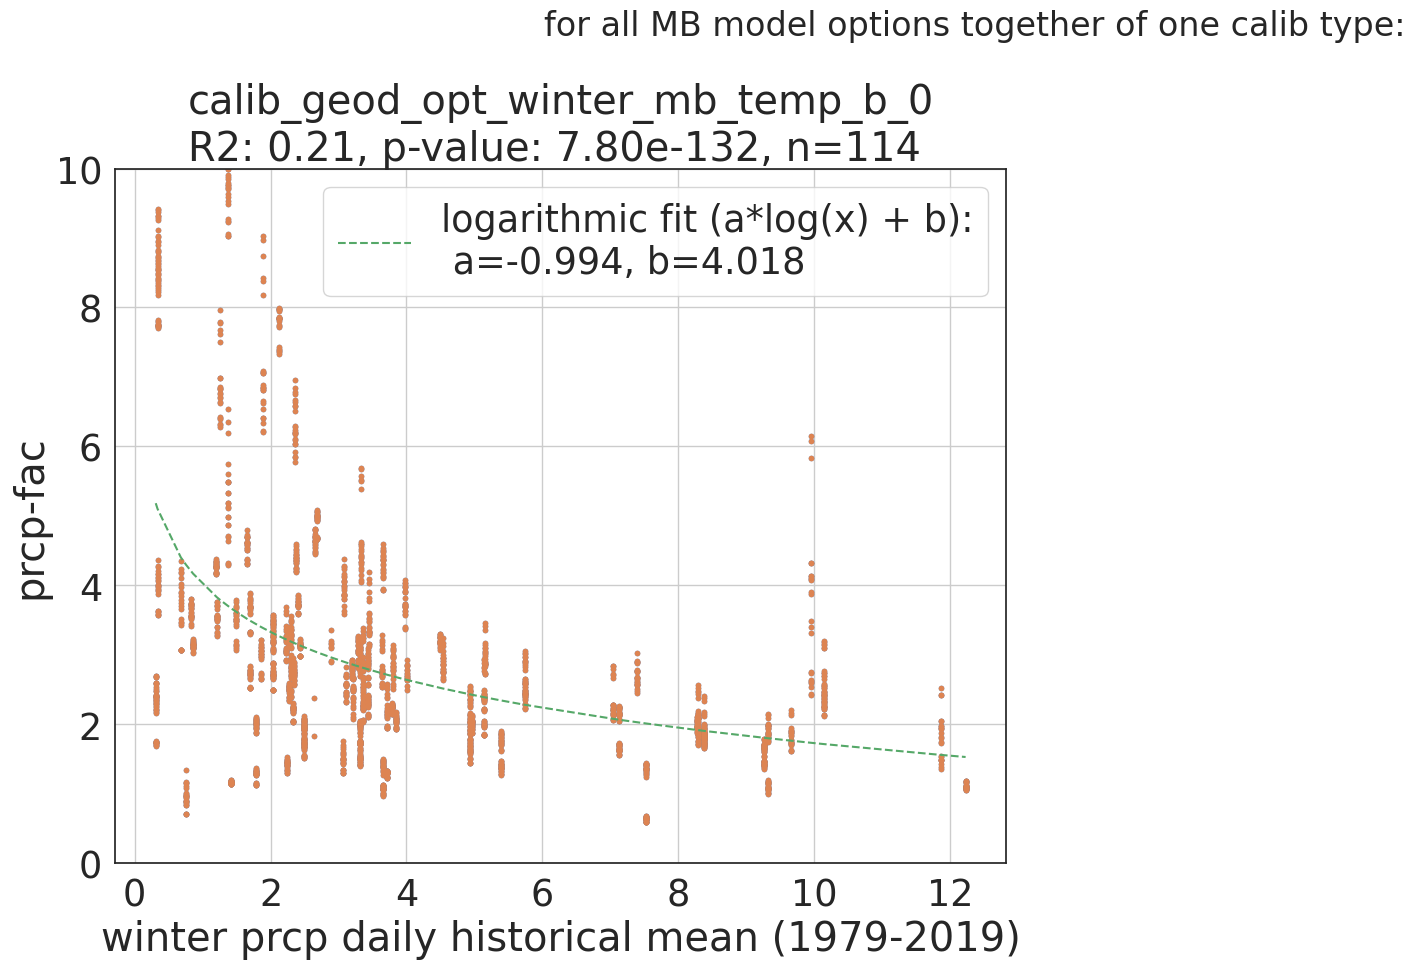

In [23]:
### first do some post-processing of the data and some pre-plots
# ATTENTION, here I use the relation 
def log_func(x, a, b):
    r = a*np.log(x) +b
    # don't allow extremely low/high prcp. factors!!!
    if len(r) == 1:
        if r > 10:
            r = 10
        if r<0.1:
            r=0.1
    else:
        r[r>10] = 10
        r[r<0.1] = 0.1
    return r

plt.figure(figsize=(20,10))
only_one_hemisphere = False #True
only_cte_grad_type = False #True #False #True #False#True
only_var_an_cycle_grad_type = False #True
hemisphere = 'all' #'nh' #'nh' #'sh' 
plt.suptitle('for all MB model options together of one calib type: ')

for j, calib_type in enumerate(['calib_geod_opt_winter_mb_temp_b_0']):
    plt.subplot(1,2,j+1)        
    pd_params_stats_t = pd_params_stats_all.loc[pd_params_stats_all.calib_type==calib_type]
    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.melt_f_update != 'annual']
    if only_cte_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'cte']
    elif only_var_an_cycle_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'var_an_cycle']
    if only_one_hemisphere:
        print(len(pd_params_stats_t.rgi_id.unique()))
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.hemisphere == hemisphere]
        print(len(pd_params_stats_t.rgi_id.unique()))
    # could also just take those that have a minimum area
    #pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.area >=0.5] # 0.15, 0.2
    plt.plot(pd_params_stats_t['daily_winter_prcp_mean_historical'], 
             pd_params_stats_t.pf_opt, '.')
    pearsonr,p_pearson = scipy.stats.pearsonr(pd_params_stats_t['daily_winter_prcp_mean_historical'],
                                                              #pd_calib_type_sel_sel.pf_opt
                                                              np.log(pd_params_stats_t.pf_opt)
                                                )
    n = len(pd_params_stats_t.rgi_id.unique())
    plt.title(f'{calib_type}\nR2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n} ')
    plt.ylabel('prcp-fac')
    plt.xlabel('winter prcp daily historical mean (1979-2019)')
    x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')

    plt.plot(x, y, '.')

    pars, cov = scipy.optimize.curve_fit(f=log_func, xdata=x,  #pd_calib_opt_wfde5['solid prcp mean nopf weighted'].dropna(),
                                         ydata=y)
                                         #bounds=(0.0001, np.inf))

    plt.plot(np.sort(x), log_func(np.sort(x), *pars), 'g--', label='logarithmic fit (a*log(x) + b):\n a=%5.3f, b=%5.3f' % tuple(pars))

    plt.legend()
    plt.ylim([0,10])
    plt.grid()
    
plt.tight_layout()


# We are only interested in calib_geod_opt_winter_mb_temp_b_0 
pd_params_stats_t.index.name = 'None'
np.testing.assert_allclose(pd_params_stats_t.groupby('rgi_id').std()['daily_winter_prcp_mean_historical'].dropna(), 0, atol=0.01)
pd_general_log_relation_pf_prcp_winter_mb_match = pd.DataFrame(pd_params_stats_t.groupby('rgi_id').mean()['daily_winter_prcp_mean_historical'])
pd_general_log_relation_pf_prcp_winter_mb_match['daily_yearly_prcp_mean_historical'] = pd_params_stats_t.groupby('rgi_id').mean()['daily_yearly_prcp_mean_historical']
pd_general_log_relation_pf_prcp_winter_mb_match['a_log_multiplier'] = pars[0]
pd_general_log_relation_pf_prcp_winter_mb_match['b_intercept'] = pars[1]
pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'] = log_func(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical'],
                                                                                    pd_general_log_relation_pf_prcp_winter_mb_match['a_log_multiplier'],
                                                                                    pd_general_log_relation_pf_prcp_winter_mb_match['b_intercept'])
#path_to_folder = '/home/lilianschuster/Schreibtisch/PhD/'
# will use that for another calibration option actually! 
#pd_general_log_relation_pf_prcp_winter_mb_match.to_csv(f'{path_to_folder}Schu
#ster_et_al_phd_paper_1/data/winter_daily_prcp_mean_general_log_relation_pf_winter_mb_match.csv')
#pd_params_stats_all.to_csv(f'{path_to_folder}Schuster_et_al_phd_paper_1/data/pd_params_dist_log_relation_pf_winter_mb_match.csv')

In [24]:
len(pd_params_stats_all.rgi_id.unique())

247

calib_geod_opt_winter_mb_temp_b_0
correlation coefficient: R²: 0.21, p-value: 7.80e-132, n=114
[-0.9938391   4.01820755]


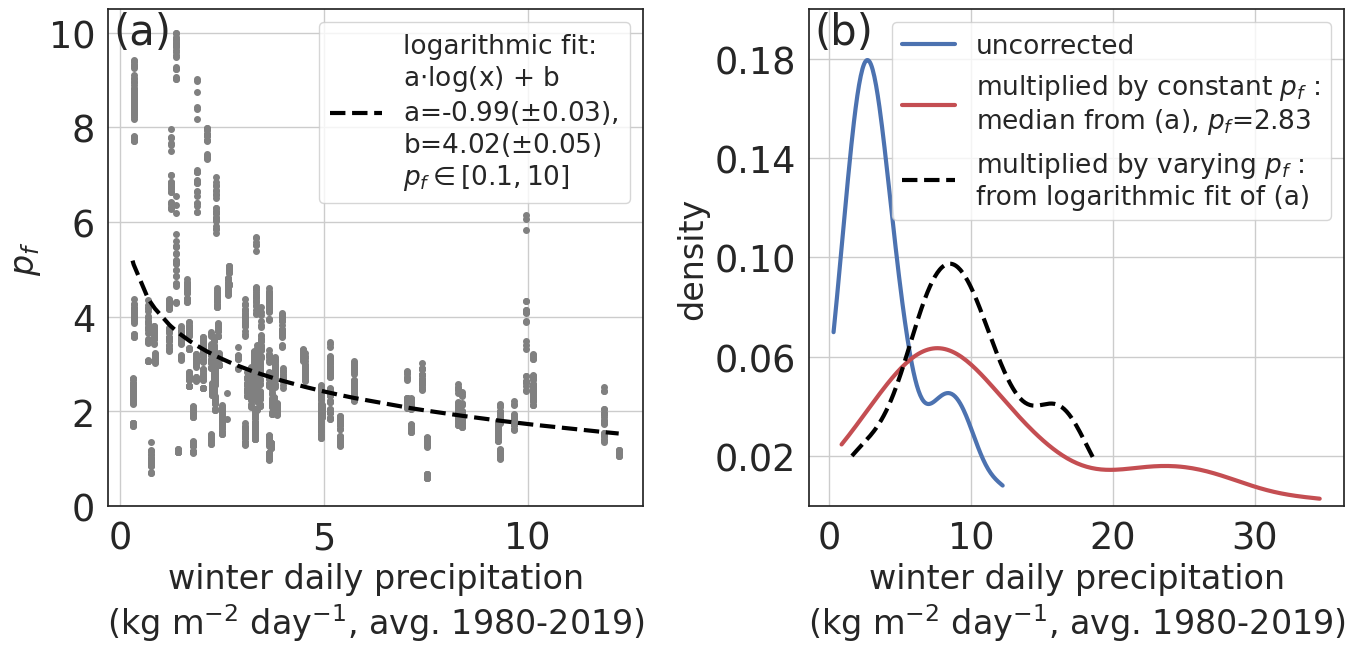

In [25]:
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)'} 
plt.rc('font', size=22)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.gca().text(0.01,0.93, num_dict[0], fontsize=30, transform=plt.gca().transAxes)

pf_median = pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'].median()

for j, calib_type in enumerate(['calib_geod_opt_winter_mb_temp_b_0']):
    pd_params_stats_t = pd_params_stats_all.loc[pd_params_stats_all.calib_type==calib_type]
    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.melt_f_update != 'annual']
    if only_cte_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'cte']
    elif only_var_an_cycle_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'var_an_cycle']
    if only_one_hemisphere:
        print(len(pd_params_stats_t.rgi_id.unique()))
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.hemisphere == hemisphere]
        print(len(pd_params_stats_t.rgi_id.unique()))
    # could also just take those that have a minimum area
    #pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.area >=0.5] # 0.15, 0.2
    n_mb_options = len(pd_params_stats_t.loc[pd_params_stats_t.rgi_id == 'RGI60-17.02128'])
    n_winter_mb = len(pd_params_stats_t.rgi_id.unique()) #
    plt.plot(pd_params_stats_t['daily_winter_prcp_mean_historical'], 
             pd_params_stats_t.pf_opt, '.', color = 'grey', ms=8)
    pearsonr,p_pearson = scipy.stats.pearsonr(pd_params_stats_t['daily_winter_prcp_mean_historical'],
                                                              #pd_calib_type_sel_sel.pf_opt
                                                              np.log(pd_params_stats_t.pf_opt)
                                                )
    n = len(pd_params_stats_t.rgi_id.unique())
    print(calib_type)
    print(f'correlation coefficient: R²: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n}')
    #plt.title(f'{calib_type}\nR2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n} ')
    plt.ylabel(r'$p_f$', fontsize=24)
    plt.xlabel('winter daily precipitation'+'\n'+ r'(kg m$^{-2}$ day$^{-1}$, avg. 1980-2019)', fontsize=24)

    x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')

    #plt.plot(x, y, '.')

    pars, pcov = scipy.optimize.curve_fit(f=log_func, xdata=x,  #pd_calib_opt_wfde5['solid prcp mean nopf weighted'].dropna(),
                                         ydata=y)
                                         #bounds=(0.0001, np.inf))
    perr = np.sqrt(np.diag(pcov))
    label_new = ('logarithmic fit:\n'+r'a$\cdot$log(x) + b'+'\n'+f'a={pars[0]:.2f}'+r'($\pm$'+f'{perr[0]:.2f}),'+'\n'+f'b={pars[1]:.2f}('+r'$\pm$'+f'{perr[1]:.2f})\n'+
             r'$p_f\in[0.1, 10]$')
            #r'$\rightarrow$ general relationship for prcp. fac')
    plt.plot(np.sort(x), log_func(np.sort(x), *pars), '--', lw=3, color = 'black',
             label=label_new) #'logarithmic fit:\n'+r'(a$\cdot$log(x) + b)'+'\n'+f'a={pars[0]:.2f}'+r'($\pm$'+f'{perr[0]:.2f})\nb={pars[1]:.2f}('+r'$\pm$'+f'{perr[1]:.2f})')

    plt.legend(fontsize=19)
    plt.ylim([0,10.5])
    plt.grid()
    

plt.subplot(122)
plt.gca().text(0.01,0.93, num_dict[2-1], fontsize=30, transform=plt.gca().transAxes)

sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical'], label='uncorrected', cut=0, lw=3)
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical']*pf_median,
            label=f'multiplied by constant'+r' $p_f$ :'+'\n'+r'median from (a), $p_f$='+f'{pf_median:.2f}', cut=0, color= 'r', lw=3)
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical']*pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'],
            label=r'multiplied by varying $p_f$ :'+'\nfrom logarithmic fit of (a)', cut=0, color='black', ls = '--', lw=3)
plt.xlabel('winter daily precipitation'+'\n'+ r'(kg m$^{-2}$ day$^{-1}$, avg. 1980-2019)', fontsize=24)
plt.ylabel('density', fontsize=24)
            #['daily_winter_prcp_mean_historical']*pd_params_stats_t['pf_opt'], label='actual optimal pf_opt')
plt.legend(fontsize=19)
plt.ylim([0,0.2])
plt.yticks(np.arange(0.02,0.19,0.04))
ax_winter=plt.gca()
plt.grid()
plt.tight_layout()
print(pars)
#plt.subplot(122)
#sns.kdeplot(pd_params_stats_t['daily_winter_prcp_mean_historical'])
#plt.savefig(f'{fig_path}/supplements/calib_log_fit_pf_distribution_change_simple.pdf')

plt.savefig(f'{fig_path}/figures_supplements/fig_S1_calib_log_fit_pf_distribution_change_simple_w_fake_pseudo_daily.pdf')

----

### Additional analysis and plots that did not made it into the manuscript or supplements:

calib_geod_opt_winter_mb_temp_b_0
correlation coefficient: R2: 0.21, p-value: 7.80e-132, n=114
[-0.9938391   4.01820755]


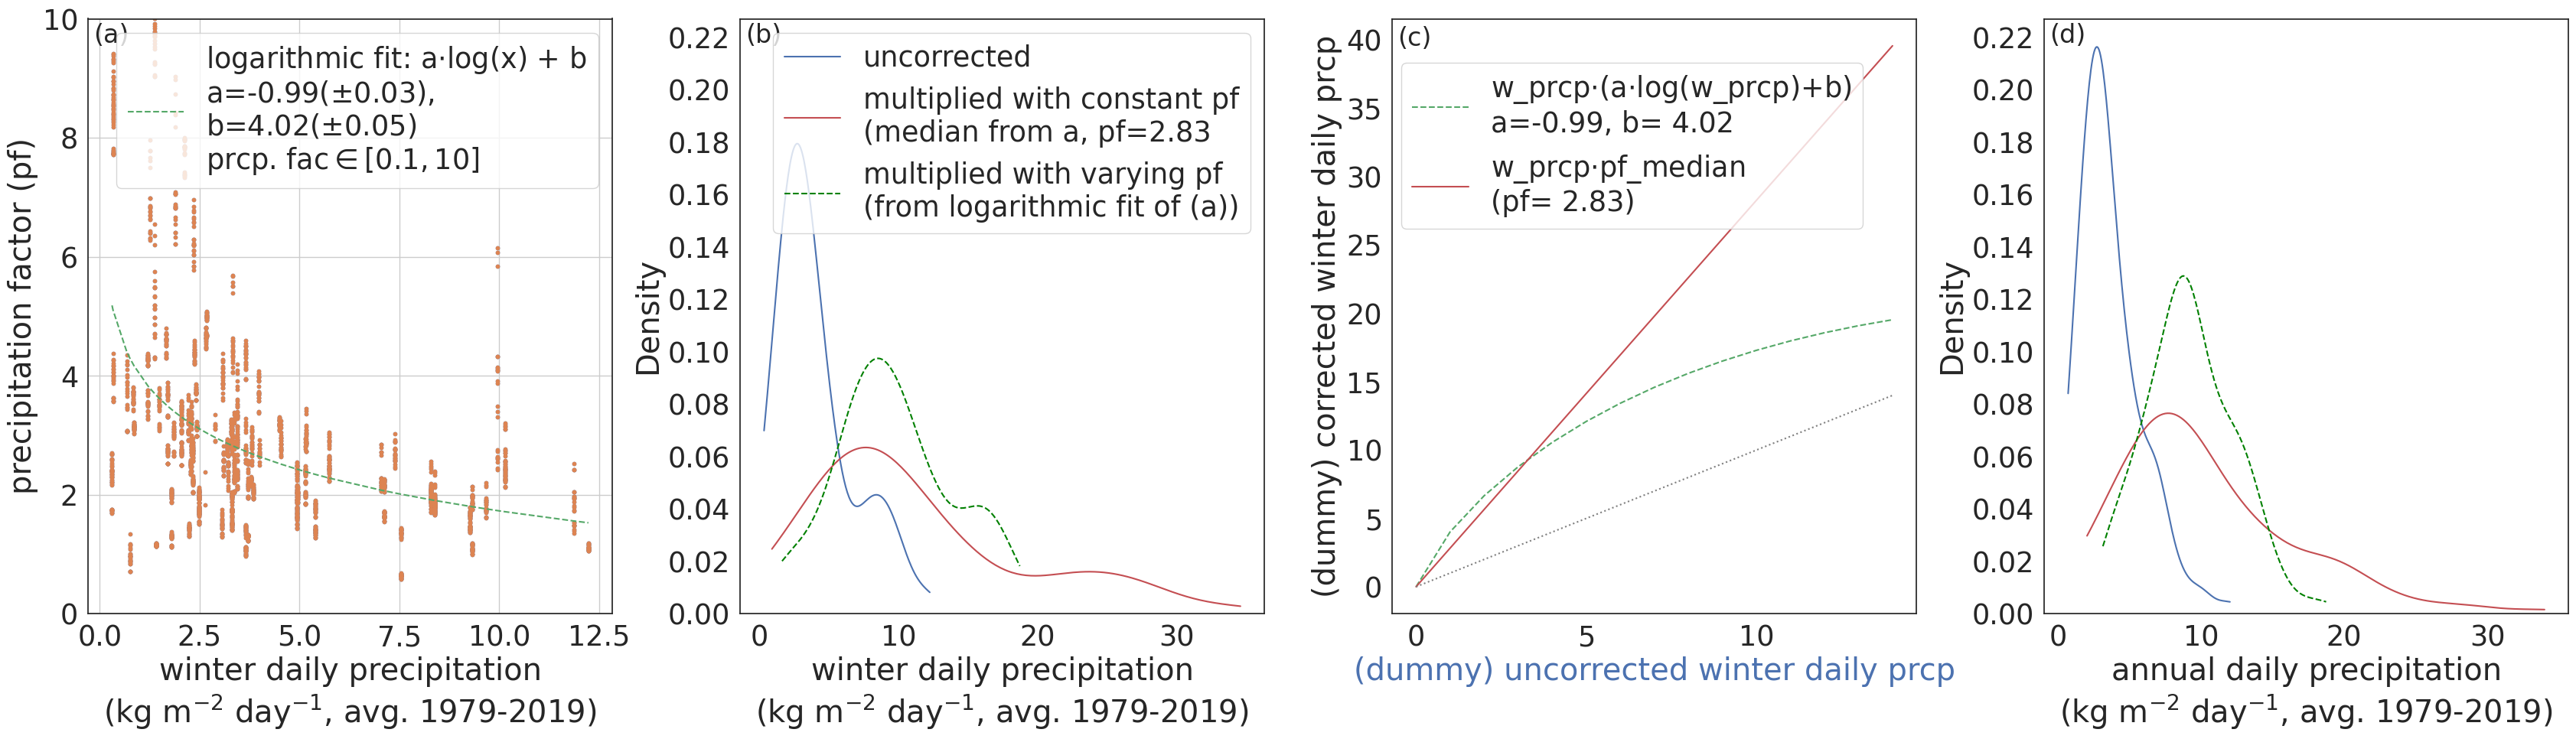

In [26]:
plt.rc('font', size=18)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)'} 
plt.figure(figsize=(34,10))
plt.subplot(1,4,1)
plt.gca().text(0.01,0.96, num_dict[0], fontsize=24, transform=plt.gca().transAxes)

pf_median = pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'].median()

for j, calib_type in enumerate(['calib_geod_opt_winter_mb_temp_b_0']):
    pd_params_stats_t = pd_params_stats_all.loc[pd_params_stats_all.calib_type==calib_type]
    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.melt_f_update != 'annual']
    if only_cte_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'cte']
    elif only_var_an_cycle_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'var_an_cycle']
    if only_one_hemisphere:
        print(len(pd_params_stats_t.rgi_id.unique()))
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.hemisphere == hemisphere]
        print(len(pd_params_stats_t.rgi_id.unique()))
    # could also just take those that have a minimum area
    #pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.area >=0.5] # 0.15, 0.2
    plt.plot(pd_params_stats_t['daily_winter_prcp_mean_historical'], 
             pd_params_stats_t.pf_opt, '.')
    pearsonr,p_pearson = scipy.stats.pearsonr(pd_params_stats_t['daily_winter_prcp_mean_historical'],
                                                              #pd_calib_type_sel_sel.pf_opt
                                                              np.log(pd_params_stats_t.pf_opt)
                                                )
    n = len(pd_params_stats_t.rgi_id.unique())
    print(calib_type)
    print(f'correlation coefficient: R2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n}')
    #plt.title(f'{calib_type}\nR2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n} ')
    plt.ylabel('precipitation factor (pf)')
    plt.xlabel('winter daily precipitation'+'\n'+ r'(kg m$^{-2}$ day$^{-1}$, avg. 1979-2019)')

    x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')

    plt.plot(x, y, '.')

    pars, pcov = scipy.optimize.curve_fit(f=log_func, xdata=x,  #pd_calib_opt_wfde5['solid prcp mean nopf weighted'].dropna(),
                                         ydata=y)
                                         #bounds=(0.0001, np.inf))
    perr = np.sqrt(np.diag(pcov))
    label_new = ('logarithmic fit: '+r'a$\cdot$log(x) + b'+'\n'+f'a={pars[0]:.2f}'+r'($\pm$'+f'{perr[0]:.2f}),'+'\n'+f'b={pars[1]:.2f}('+r'$\pm$'+f'{perr[1]:.2f})\n'+
             r'prcp. fac$\in[0.1, 10]$')
            #r'$\rightarrow$ general relationship for prcp. fac')
    plt.plot(np.sort(x), log_func(np.sort(x), *pars), 'g--',
             label=label_new) #'logarithmic fit:\n'+r'(a$\cdot$log(x) + b)'+'\n'+f'a={pars[0]:.2f}'+r'($\pm$'+f'{perr[0]:.2f})\nb={pars[1]:.2f}('+r'$\pm$'+f'{perr[1]:.2f})')

    plt.legend()
    plt.ylim([0,10])
    plt.grid()
    
plt.tight_layout()

plt.subplot(142)
plt.gca().text(0.01,0.96, num_dict[2-1], fontsize=24, transform=plt.gca().transAxes)

sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical'], label='uncorrected', cut=0)
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical']*pf_median, label=f'multiplied with constant pf\n(median from a, pf={pf_median:.2f}', cut=0, color= 'r')
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical']*pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'],
            label='multiplied with varying pf\n(from logarithmic fit of (a))', cut=0, color='green', ls = '--')
plt.xlabel('winter daily precipitation'+'\n'+ r'(kg m$^{-2}$ day$^{-1}$, avg. 1979-2019)')

            #['daily_winter_prcp_mean_historical']*pd_params_stats_t['pf_opt'], label='actual optimal pf_opt')
plt.legend()
plt.yticks(np.arange(0,0.19,0.02))
ax_winter=plt.gca()


plt.subplot(143)
plt.gca().text(0.01,0.955, num_dict[3-1], fontsize=24, transform=plt.gca().transAxes)

d_prcp_dummy = np.arange(0,15,1)
plt.plot(d_prcp_dummy, d_prcp_dummy*log_func(d_prcp_dummy,*pars), label=r'w_prcp$\cdot$(a$\cdot$log(w_prcp)+b)'+'\na=%5.2f, b=%5.2f' % tuple(pars), color='g', ls = '--')
plt.plot(d_prcp_dummy, d_prcp_dummy*pf_median, color = 'r', label=r'w_prcp$\cdot$pf_median'+'\n(pf=%5.2f)' %pf_median)

plt.plot(d_prcp_dummy, d_prcp_dummy, ls=':', color = 'grey')
plt.xlabel('(dummy) uncorrected winter daily prcp', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]) # want the right blue
plt.ylabel('(dummy) corrected winter daily prcp') #\n(pf obtained from log. regression)') #, color = 'g')
plt.legend(loc='upper left', bbox_to_anchor=(-0.01,0.95))

plt.subplot(144,sharey=ax_winter)
plt.gca().text(0.01,0.96, num_dict[4-1], fontsize=24, transform=plt.gca().transAxes)

sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_yearly_prcp_mean_historical'], label='uncorrected', cut=0)
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_yearly_prcp_mean_historical']*pf_median, label=f'multiplied with cte median pf={pf_median:.2f}', cut=0, color= 'r')
sns.kdeplot(pd_general_log_relation_pf_prcp_winter_mb_match['daily_yearly_prcp_mean_historical']*pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'],
            label='multiplied with pf\n(obtained from log. regression)', cut=0, color='green', ls = '--')
plt.xlabel('annual daily precipitation'+'\n'+ r'(kg m$^{-2}$ day$^{-1}$, avg. 1979-2019)')
plt.yticks(np.arange(0,0.24,0.02))
plt.tight_layout()
print(pars)
#plt.subplot(122)
#sns.kdeplot(pd_params_stats_t['daily_winter_prcp_mean_historical'])
#plt.savefig(f'{fig_path}/supplements/calib_log_fit_pf_distribution_change.pdf')

### Plots with only calibration option C5 and fewer options for Cryosphere 2022 poster:

In [27]:
fs = []
for m,_g in zip(pd_params_stats['mb_type'], pd_params_stats['grad_type']):
    if _g == 'cte':
        g = ', constant temp. lapse rate'
    elif _g == 'var_an_cycle':
        g = ', variable temp. lapse rate'
    else:
        print('problem')
    if m == 'mb_real_daily':
        m = 'daily'
    elif m == 'mb_monthly':
        m = 'monthly'
    fs.append(m+g)
    


pd_params_stats['mb_grad_type'] = fs

hue_order = ['monthly, constant temp. lapse rate', 'monthly, variable temp. lapse rate',
             'daily, constant temp. lapse rate', 'daily, variable temp. lapse rate']

In [28]:
ref_working_l = []
pd_working_check = pd_params_stats.loc[pd_params_stats.calib_type=='calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
for grad_type in ['cte', 'var_an_cycle']:
    pd_working_check_grad =  pd_working_check.loc[pd_working_check.grad_type ==grad_type]
    for mb_type in ['mb_monthly', 'mb_real_daily']:
        pd_working_check_mb_type =  pd_working_check_grad.loc[pd_working_check_grad.mb_type ==mb_type]
        for melt_f_change in ['False', 'linear\nmonthly']:
            pd_working_check_single = pd_working_check_mb_type.loc[pd_working_check_mb_type.sfc_type ==melt_f_change]
            r = pd_working_check_single.index.unique()
            ref_working_l.append(r)
            print(f'{grad_type}, {mb_type}, {melt_f_change[:5]}: n={len(r)}')
working_rgis_common = ref_working_l[0]
for j,k in enumerate(ref_working_l[1:]):
    working_rgis_common = list(set(working_rgis_common).intersection(ref_working_l[j]))

cte, mb_monthly, False: n=218
cte, mb_monthly, linea: n=213
cte, mb_real_daily, False: n=226
cte, mb_real_daily, linea: n=221
var_an_cycle, mb_monthly, False: n=230
var_an_cycle, mb_monthly, linea: n=224
var_an_cycle, mb_real_daily, False: n=238
var_an_cycle, mb_real_daily, linea: n=232


In [29]:
len(working_rgis_common)
pd_params_stats = pd_params_stats.loc[working_rgis_common]

In [30]:
# to convert monthly melt_f to daily units
fac_per_month_to_per_day = 365.25/12
fac_per_month_to_per_day

30.4375

2.8270283408160584
calib_geod_opt_winter_mb_temp_b_0
correlation coefficient: R2: 0.21, p-value: 7.80e-132, n=114


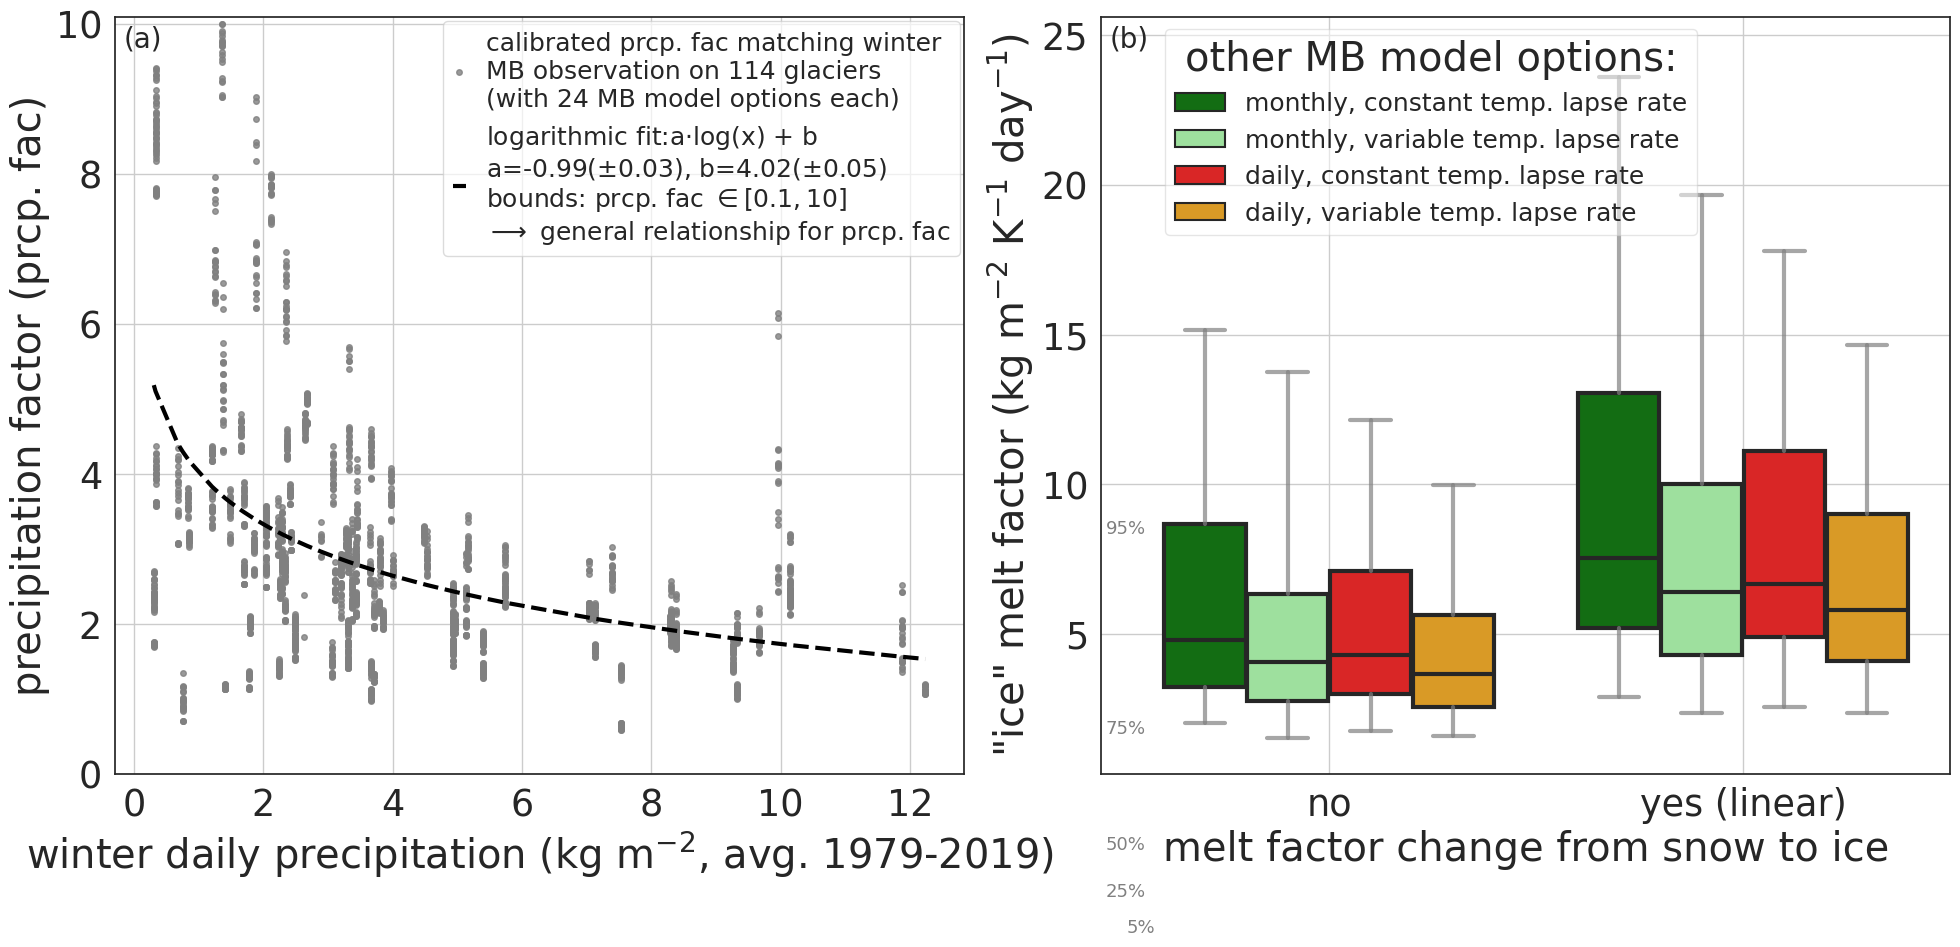

In [35]:
plt.rc('font', size=20)

calib_types = ['calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
#sns.set(font_scale=1.5)
#sns.set_style('white')

col_pal = sns.color_palette(['green','lightgreen',#'blue','lightblue',
                             'red', 'orange'])

def log_func(x, a, b):
    return a*np.log(x) +b

fig, axs = plt.subplots(1, 2, #sharex=True, #sharey=True,
                            figsize=(20,10)) # 30, 15

#####
plt.rc
plt.subplot(1,2,1)
plt.gca().text(0.01,0.96, '(a)', fontsize=20, transform=plt.gca().transAxes)

pf_median = pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'].median()
print(pf_median)
for j, calib_type in enumerate(['calib_geod_opt_winter_mb_temp_b_0']):
    pd_params_stats_t = pd_params_stats_all.loc[pd_params_stats_all.calib_type==calib_type]
    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.melt_f_update != 'annual']
    n_mb_options = len(pd_params_stats_t.loc[pd_params_stats_t.rgi_id == 'RGI60-17.02128'])
    n_winter_mb = len(pd_params_stats_t.rgi_id.unique())
    #if only_cte_grad_type:
    #    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'cte']
    #elif only_var_an_cycle_grad_type:
    #    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'var_an_cycle']
    #if only_one_hemisphere:
    #    print(len(pd_params_stats_t.rgi_id.unique()))
    #    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.hemisphere == hemisphere]
    #    print(len(pd_params_stats_t.rgi_id.unique()))
    # could also just take those that have a minimum area
    #pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.area >=0.5] # 0.15, 0.2
    plt.plot(pd_params_stats_t['daily_winter_prcp_mean_historical'], 
             pd_params_stats_t.pf_opt, '.',color = 'grey', ms=8,
             alpha = 0.8, label = f'calibrated prcp. fac matching winter\nMB observation on {n_winter_mb} glaciers\n(with {n_mb_options} MB model options each)')
    pearsonr,p_pearson = scipy.stats.pearsonr(pd_params_stats_t['daily_winter_prcp_mean_historical'],
                                                              #pd_calib_type_sel_sel.pf_opt
                                                              np.log(pd_params_stats_t.pf_opt)
                                                )
    n = len(pd_params_stats_t.rgi_id.unique())
    print(calib_type)
    print(f'correlation coefficient: R2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n}')
    #plt.title(f'{calib_type}\nR2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n} ')
    plt.ylabel('precipitation factor (prcp. fac)')
    plt.xlabel(r'winter daily precipitation (kg m$^{-2}$, avg. 1979-2019)')
    x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')
    #x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    #y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')

    #plt.plot(x, y, '.', color = 'grey', alpha = 0.5)

    pars, pcov = scipy.optimize.curve_fit(f=log_func, xdata=x,  #pd_calib_opt_wfde5['solid prcp mean nopf weighted'].dropna(),
                                         ydata=y)
                                         #bounds=(0.0001, np.inf))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(np.sort(x), log_func(np.sort(x), *pars), '--', color ='black',lw = 3,
             label='logarithmic fit:'+r'a$\cdot$log(x) + b'+'\n'+f'a={pars[0]:.2f}'+r'($\pm$'+f'{perr[0]:.2f}), b={pars[1]:.2f}('+r'$\pm$'+f'{perr[1]:.2f})\n'+
             r'bounds: prcp. fac $\in[0.1, 10]$'+'\n'+
            r'$\longrightarrow$ general relationship for prcp. fac')

    plt.legend(loc = 'upper right', bbox_to_anchor=(1.01,1.01), fontsize=18, framealpha = 0.7, handlelength=0.5)
    plt.ylim([0,10.1])
    plt.grid()
    
plt.tight_layout()

#################
order = ['False', 'linear\nmonthly'  #'linear\nannual',
           #'neg_exp\nmonthly', #'neg_exp\nannual'
            ]
order2 = ['False', 'linear\nmonthly']
          #'neg_exp\nmonthly_t1yr']

j = 0
p=1
axs[p].text(0.01,0.96, '(b)', fontsize=20, transform=axs[p].transAxes)
for _,param in enumerate(['melt_f']): #, 'pf_opt', 'temp_bias']):
    #plt.plot(figsize=(30,20))
    for c,calib_type in enumerate(calib_types):
        if (calib_type == 'calib_only_geod_temp_b_0_cte_via_std') and (param == 'pf_opt'):
            marker = 's'
        else:
            marker = "8"
        pd_tt = pd_params_stats.loc[pd_params_stats.calib_type==calib_type]
        pd_tt = pd_tt.loc[(pd_tt.sfc_type != 'neg_exp\nannual_t1yr') & (pd_tt.sfc_type != 'linear\nannual')]
        if True:
            g=sns.boxplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type', palette=col_pal, ax = axs[p], #order=order,
                            dodge=0.3, #join=False,
                         # n_boot=10000,
                            order = order2, hue_order=hue_order,
                          fliersize=0, whis = [5,95],  #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7})
                         #showmeans=True,
                      #whis=0,
                      #flierprops = dict(markerfacecolor='silver', markersize=6,
                      #    markeredgecolor='none'),
                        #   meanprops={"marker": marker,
                        #       "markeredgecolor": "grey",
                        #       "markerfacecolor": "grey",
                        #       "markersize": "7"})
        else:
            g=sns.pointplot(y=param, data=pd_tt, hue='mb_grad_type', x='sfc_type', palette=col_pal, ax = axs[p], #order=order,
                            dodge=0.3, join=False, n_boot=10000,
                            order = order2, hue_order=hue_order,
                         #showmeans=True,
                      #whis=0,
                      #flierprops = dict(markerfacecolor='silver', markersize=6,
                      #    markeredgecolor='none'),
                    meanprops={"marker": marker,
                               "markeredgecolor": "grey",
                               "markerfacecolor": "grey",
                               "markersize": "7"})  
        g.set_xlabel('surface type distinction')
        g.legend(loc='upper left', bbox_to_anchor=(0.06,1), framealpha =0.5, fontsize=18)
        g.legend_.set_title('other MB model options:')
        #if c!=4 or p!= 2:
        #g.get_legend().remove()
        #if p == 0:
        #    axs[p].set_title(calib_type[6:], fontsize=18)
        #    #axs[p].text(-0.8,355, num_dict[c], fontsize=20)
        axs[p].set_xticklabels(['no', 'yes (linear)'])

        #if p!= 2:
        axs[p].set_xlabel('melt factor change from snow to ice')
        axs[p].grid()
        if c!=0:
            axs[p].set_ylabel('')
            axs[p].set_yticklabels('')
        if param=='pf_opt':
            axs[p].set_ylim([1.8,4.3])
        elif param == 'melt_f':
            axs[p].set_ylim(np.array([10,780])/fac_per_month_to_per_day)
        j += 1
        axs[p].set_ylabel(r'"ice" melt factor (kg m$^{-2}$ K$^{-1}$ day$^{-1}$)')
        
        qs = pd_tt.groupby(['mb_grad_type', 'sfc_type']).melt_f.quantile([0.05,0.25,0.5,0.75,0.95]).loc[('monthly, constant temp. lapse rate', 'False')].values
        for ps,q in enumerate(qs):
            perci = [5,25,50,75,95][ps]
            if perci == 5:
                axs[p].text(-0.49,q-7,f'{perci}%', color = 'grey', fontsize=13)
            else:
                axs[p].text(-0.54,q-7,f'{perci}%', color = 'grey', fontsize=13)
        axs[p].set_xlim([-0.55,1.5])
plt.tight_layout(w_pad=0.8, h_pad=0.4)
#plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/additional/calib_params_stats_point_plot.pdf')
#plt.savefig(f'/home/lilianschuster/Schreibtisch/PhD/frequentist_ref_glacier_calib/to_show_mar2022/calib_params_stats_point_plot.pdf')
#plt.savefig(f'../figures/poster_param_distrib.pdf')
#plt.savefig(f'../figures/poster_param_distrib.svg', format = 'svg')